# Обучение свёрточной нейронной сети.  
Загружаем пред обработанные данные.

In [165]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
# from six.moves import range
from matplotlib.pyplot import imshow


In [166]:
pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


Используем приём усиливающий контрастность (разность) между схожими свойствами на одной карте свойств и на соседних картах свойств, [статья](http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf).

[[0.00650554]]
[[0.01129725]]


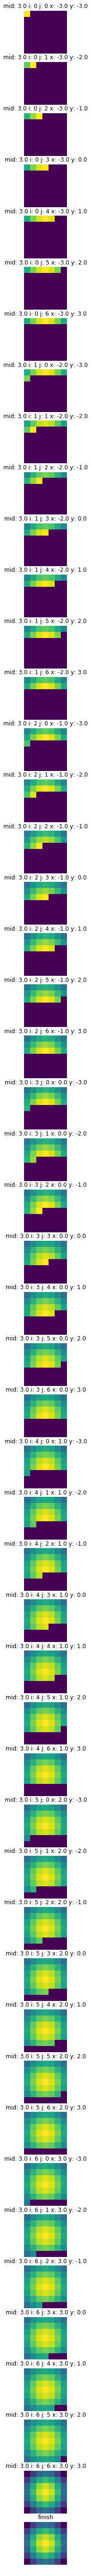

In [176]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """
    Local Contrast Normalization
    :param X: tf_train_dataset
    :param image_shape: [batch_size, image_size, image_size, num_channels]
    """
    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)
    
    plt.rcParams['figure.figsize'] = (45.0, 100.0)    
    f, ax = plt.subplots(nrows= radius * radius + 1, ncols=1)
    [i.axis('off') for i in ax]
       
    filters, filters_asarray = gaussian_filter(filter_shape, ax)
    # TODO
    return
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter_(kernel_shape, ax):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)


def gaussian_filter(kernel_shape, ax):
    # The Gaussian filter of the desired size initialized to zero
    filter_ = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)  # Middle of kernel of Gaussian filter
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):  # go on width of Gaussian weighting window
            for j in range(0, kernel_shape[1]):  # go on height of Gaussian weighting window
                filter_[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
                _ = [i.ravel() for i in filter_]
                ax[kernel_shape[0] * i + j].set_title(
                    f"mid: {mid} i: {i} j: {j} x: {i - mid} y: {j - mid}", loc='center'
                )
                ax[kernel_shape[0] * i + j].imshow([i.ravel() for i in filter_])
    
    filter_ = filter_ / np.sum(filter_)    
    ax[kernel_shape[0] * kernel_shape[1]].set_title(f"finish", loc='center')
    ax[kernel_shape[0] * kernel_shape[1]].imshow([i.ravel() for i in filter_])
    return tf.convert_to_tensor(filter_, dtype=tf.float32), filter_


def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) \
            / predictions.shape[1] / predictions.shape[0])


image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]
LCN = LecunLCN(train_dataset, shape)

In [35]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]
LCN = LecunLCN(train_dataset, shape)

(7, 7, 1, 1)


NameError: name 'xrange' is not defined